# Causal Impact of Contributions on Member Churn

## Preamble & Imports

In [68]:
import os
import optuna
import re
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

from dowhy import CausalModel
from econml.dml import CausalForestDML
from rapidfuzz import process, fuzz
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from sklearn.model_selection import ParameterGrid

# Suppress Warnings
warnings.filterwarnings('ignore')

## Integrate Data on Contributions, Membership, and Morbidity Indicators

### Helpers

In [33]:
manual_fixes = {
    'bkk dürkopp adler': 'bkk dürkoppadler',                     # consistent spelling
    'bkk der mtu friedrichshafen': 'bkk mtu',                    # full official name
    'ikk - die innovationskasse': 'ikk – die innovationskasse',  # unify dash
    'hanseatische krankenkasse (hek)': 'hek',                    # full name
    'techniker krankenkasse (tk)': 'techniker-krankenkasse (tk)',# unify name
    'bkk metzinger': 'metzinger bkk'                             # consistent spelling
}

In [39]:
# Define file paths and sheet names
base_path = "../data/"
files = {
    "contribution": ("Zusatzbeitrag_je Kasse je Quartal.xlsx", "Sheet1"),
    "morbidity": ("Morbidity_Region.xlsx", "data"),
    "market": ("Marktanteile je Kasse.xlsx", "data")
}

# Load all data into a dictionary of DataFrames
dataframes = {}
for name, (filename, sheetname) in files.items():
    full_path = os.path.join(base_path, filename)
    df = pd.read_excel(full_path, sheet_name=sheetname)
    
    # Clean names and year
    df["Krankenkasse"] = df["Krankenkasse"].astype(str).str.strip().str.lower()
    df["Jahr"] = df["Jahr"].astype(int)
    dataframes[name] = df
    
# Apply these 8 manual fixes to morbidity
dataframes["morbidity"]["Krankenkasse"] = dataframes["morbidity"]["Krankenkasse"].replace(manual_fixes)

# Apply these 8 manual fixes to market
dataframes["market"]["Krankenkasse"] = dataframes["market"]["Krankenkasse"].replace(manual_fixes)

# Merge all datasets into one DataFrame
merged = pd.merge(
    dataframes["contribution"],
    dataframes["morbidity"][["Krankenkasse", "Jahr", "Risikofaktor"]],
    on=["Krankenkasse", "Jahr"],
    how="left"
)
merged = pd.merge(
    merged,
    dataframes["market"][["Krankenkasse", "Jahr", "Marktanteil Mitglieder", "Marktanteil Versicherte"]],
    on=["Krankenkasse", "Jahr"],
    how="left"
)

# Preview the first rows and check for missing values
print(merged.head(10))
print("\nMissing values per column:\n", merged.isnull().sum())

   Jahr                  Krankenkasse  Quartal  Mitglieder  Versicherte  \
0  2025         aok baden-württemberg        1     3539685      4615478   
1  2025                    aok bayern        1     3627408      4603276   
2  2025        aok bremen/bremerhaven        1      207431       284469   
3  2025                    aok hessen        1     1281555      1730176   
4  2025             aok niedersachsen        1     2324317      3058918   
5  2025                   aok nordost        1     1303932      1619468   
6  2025                  aok nordwest        1     2224273      2960003   
7  2025                      aok plus        1     2767866      3491693   
8  2025  aok rheinland-pfalz/saarland        1      934209      1225364   
9  2025         aok rheinland/hamburg        1     2239511      2999282   

   Zusatzbeitrag Risikofaktor  Marktanteil Mitglieder Marktanteil Versicherte  
0           2.60     0.906069                0.061221                0.062775  
1           2.

## Exploratory Data Analysis

Number of unique funds: 131
Years: [2025 2024 2023 2022 2021 2020 2019 2018 2017 2016 2015 2014 2013]
Quarters: [1 2 3 4]


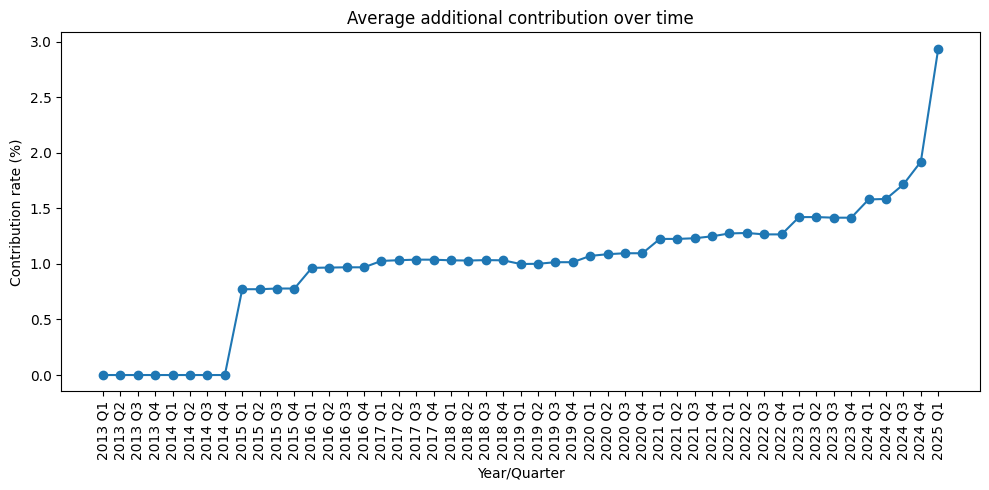

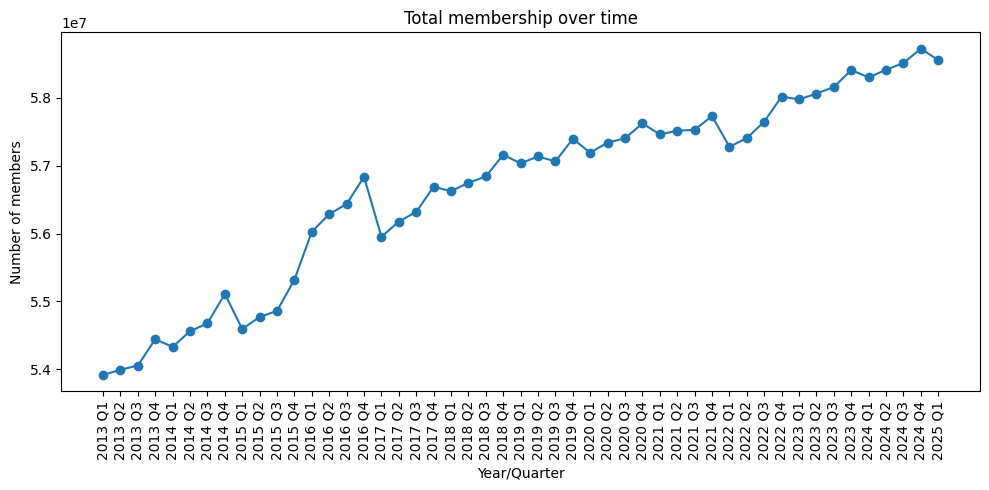

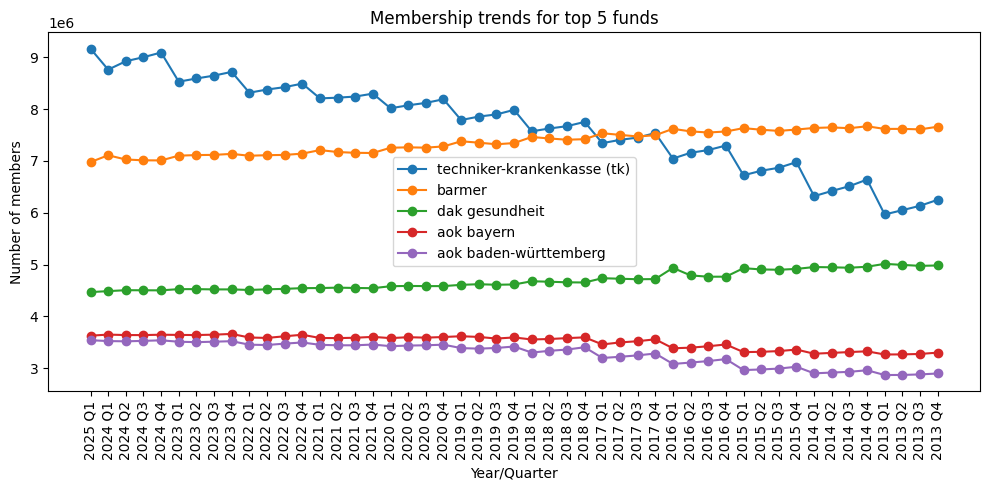

In [40]:
# 1. Basic overview: Number of funds, years, and quarters
print("Number of unique funds:", merged['Krankenkasse'].nunique())
print("Years:", merged['Jahr'].unique())
print("Quarters:", merged['Quartal'].unique())

# 2. Average additional contribution per quarter (all funds)
avg_contribution = merged.groupby(['Jahr', 'Quartal'])['Zusatzbeitrag'].mean().reset_index()
plt.figure(figsize=(10,5))
plt.plot(
    avg_contribution['Jahr'].astype(str) + ' Q' + avg_contribution['Quartal'].astype(str),
    avg_contribution['Zusatzbeitrag'], marker='o'
)
plt.title('Average additional contribution over time')
plt.xlabel('Year/Quarter')
plt.ylabel('Contribution rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. Total membership over time (all funds)
total_members = merged.groupby(['Jahr', 'Quartal'])['Mitglieder'].sum().reset_index()
plt.figure(figsize=(10,5))
plt.plot(
    total_members['Jahr'].astype(str) + ' Q' + total_members['Quartal'].astype(str),
    total_members['Mitglieder'], marker='o'
)
plt.title('Total membership over time')
plt.xlabel('Year/Quarter')
plt.ylabel('Number of members')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 4. Top 5 funds: membership development over time
top_funds = merged.groupby('Krankenkasse')['Mitglieder'].sum().sort_values(ascending=False).head(5).index.tolist()
plt.figure(figsize=(10,5))
for fund in top_funds:
    temp = merged[merged['Krankenkasse'] == fund]
    plt.plot(
        temp['Jahr'].astype(str) + ' Q' + temp['Quartal'].astype(str),
        temp['Mitglieder'], marker='o', label=fund
    )
plt.title('Membership trends for top 5 funds')
plt.xlabel('Year/Quarter')
plt.ylabel('Number of members')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

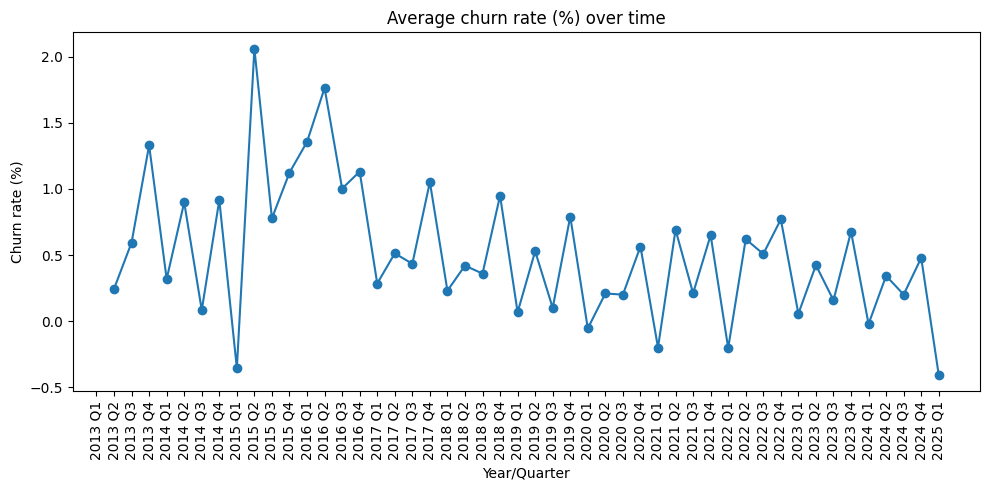

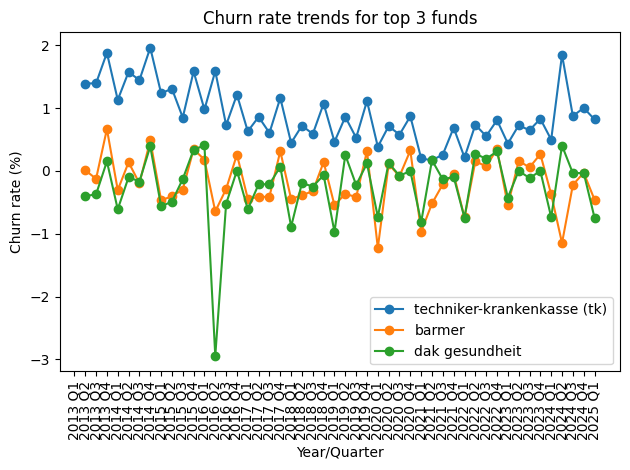

In [41]:
# 1. Sort data and calculate churn per fund and quarter
merged = merged.sort_values(['Krankenkasse', 'Jahr', 'Quartal'])
merged['members_prev'] = merged.groupby('Krankenkasse')['Mitglieder'].shift(1)
merged['churn_abs'] = merged['Mitglieder'] - merged['members_prev']
merged['churn_rel'] = merged['churn_abs'] / merged['members_prev'] * 100

# Calculate contribution rate change
merged['Zusatzbeitrag_prev'] = merged.groupby('Krankenkasse')['Zusatzbeitrag'].shift(1)
merged['rate_change'] = merged['Zusatzbeitrag'] - merged['Zusatzbeitrag_prev']
merged['rate_bucket'] = pd.cut(merged['rate_change'], bins=[-1, -0.01, 0.01, 1],
                               labels=['cut', 'no_change', 'increase'])

# 2. Average churn rate per quarter (all funds)
avg_churn = merged.groupby(['Jahr', 'Quartal'])['churn_rel'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(
    avg_churn['Jahr'].astype(str) + ' Q' + avg_churn['Quartal'].astype(str),
    avg_churn['churn_rel'], marker='o'
)
plt.title('Average churn rate (%) over time')
plt.xlabel('Year/Quarter')
plt.ylabel('Churn rate (%)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# 3. Churn trends for the top 3 funds
for fund in top_funds[:3]:
    temp = merged[merged['Krankenkasse'] == fund]
    plt.plot(
        temp['Jahr'].astype(str) + ' Q' + temp['Quartal'].astype(str),
        temp['churn_rel'], marker='o', label=fund
    )
plt.title('Churn rate trends for top 3 funds')
plt.xlabel('Year/Quarter')
plt.ylabel('Churn rate (%)')
plt.legend()
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Top and bottom 10 funds by average churn rate
avg_churn_by_fund = merged.groupby('Krankenkasse')['churn_rel'].mean().sort_values()
top10_churn = avg_churn_by_fund.tail(10)
bottom10_churn = avg_churn_by_fund.head(10)

print(f'Top 10 Churning Funds: \n\n{top10_churn}\n')
print(f'Bottom 10 Churning Funds: \n\n{bottom10_churn}')

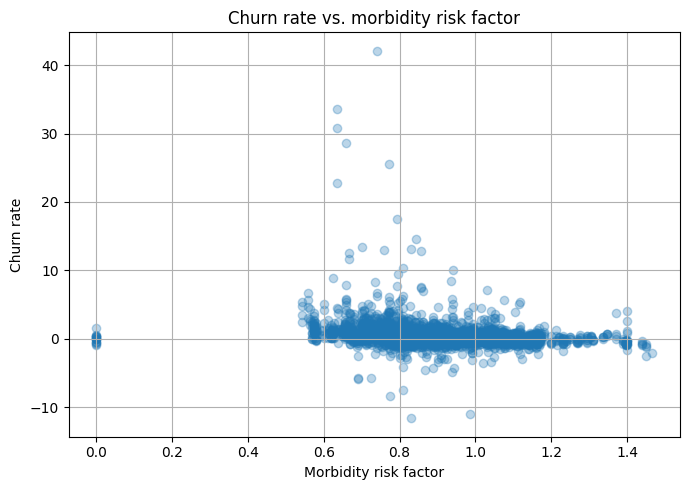

Correlation (churn rate ~ morbidity risk factor): -0.21914972090540366


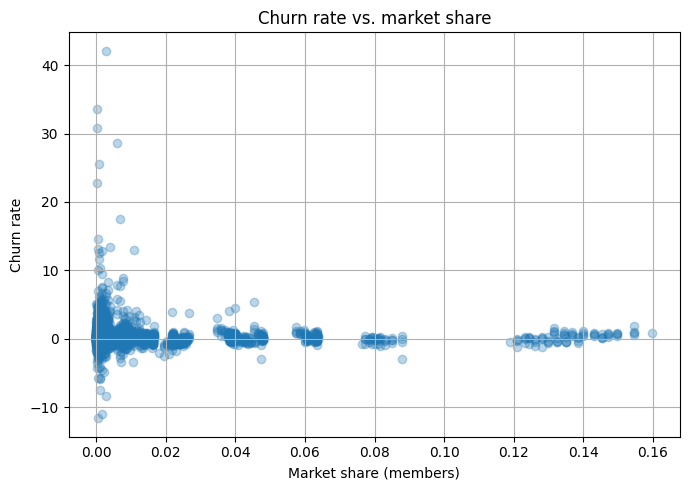

Correlation (churn rate ~ market share): -0.05980569279135501


In [42]:
# Scatterplot and correlation: Churn rate vs. morbidity risk factor
rf_mask = pd.to_numeric(merged['Risikofaktor'], errors='coerce').notnull() & merged['churn_rel'].notnull()
rf_vals = pd.to_numeric(merged.loc[rf_mask, 'Risikofaktor'])
churn_vals = merged.loc[rf_mask, 'churn_rel']

plt.figure(figsize=(7,5))
plt.scatter(rf_vals, churn_vals, alpha=0.3)
plt.xlabel('Morbidity risk factor')
plt.ylabel('Churn rate')
plt.title('Churn rate vs. morbidity risk factor')
plt.grid(True)
plt.tight_layout()
plt.show()

corr_rf = np.corrcoef(rf_vals, churn_vals)[0,1]
print("Correlation (churn rate ~ morbidity risk factor):", corr_rf)

# Scatterplot and correlation: Churn rate vs. market share (members)
ma_mask = pd.to_numeric(merged['Marktanteil Mitglieder'], errors='coerce').notnull() & merged['churn_rel'].notnull()
ma_vals = pd.to_numeric(merged.loc[ma_mask, 'Marktanteil Mitglieder'])
churn_vals_ma = merged.loc[ma_mask, 'churn_rel']

plt.figure(figsize=(7,5))
plt.scatter(ma_vals, churn_vals_ma, alpha=0.3)
plt.xlabel('Market share (members)')
plt.ylabel('Churn rate')
plt.title('Churn rate vs. market share')
plt.grid(True)
plt.tight_layout()
plt.show()

corr_ma = np.corrcoef(ma_vals, churn_vals_ma)[0,1]

print("Correlation (churn rate ~ market share):", corr_ma)

### Correlation Interpretation 

#### Churn vs. Morbidity Risk Factor: −0.22
    → Slight negative correlation, suggesting sicker populations may churn slightly less.
    
#### Churn vs. Market Share (Members): −0.09 
    → Weak negative correlation — larger funds may retain members a bit better, but not strongly.

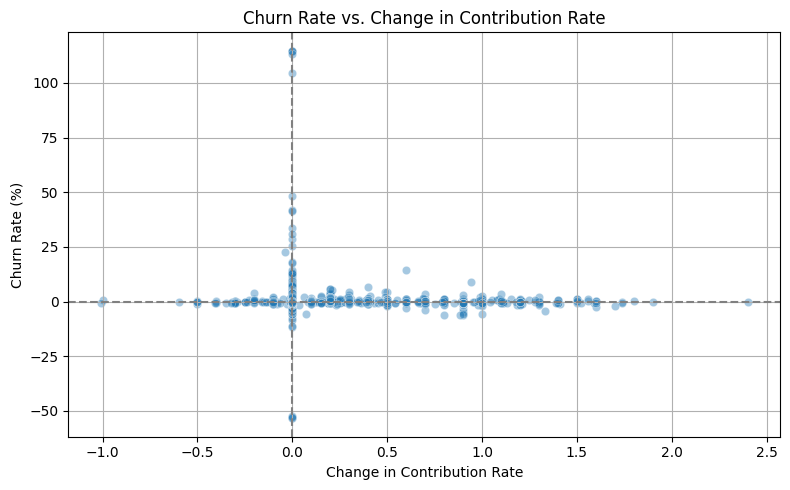

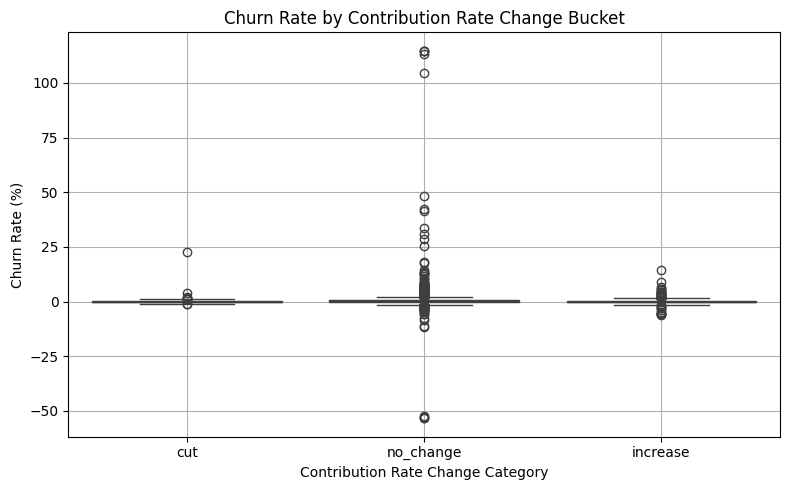

In [43]:
# 1. Scatter plot: Churn rate vs. contribution rate change
scatter_data = merged[(merged['churn_rel'].notnull()) & (merged['rate_change'].notnull())]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=scatter_data, x='rate_change', y='churn_rel', alpha=0.4)
plt.axhline(0, color='grey', linestyle='--')
plt.axvline(0, color='grey', linestyle='--')
plt.title('Churn Rate vs. Change in Contribution Rate')
plt.xlabel('Change in Contribution Rate')
plt.ylabel('Churn Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Boxplot: Churn rate by rate change bucket
box_data = merged[(merged['churn_rel'].notnull()) & (merged['rate_bucket'].notnull())]

plt.figure(figsize=(8, 5))
sns.boxplot(data=box_data, x='rate_bucket', y='churn_rel')
plt.title('Churn Rate by Contribution Rate Change Bucket')
plt.xlabel('Contribution Rate Change Category')
plt.ylabel('Churn Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


## Causal Analysis

### Difference in Differences (DiD)

In [44]:
did_initial = merged.copy()

# Mark treatment: rate increased compared to previous quarter
did_initial['treatment'] = (did_initial['rate_change'] > 0).astype(int)

# Detect first increase per fund
first_increase = did_initial[did_initial['treatment'] == 1].groupby('Krankenkasse')[['Jahr', 'Quartal']].first().reset_index()
first_increase.columns = ['Krankenkasse', 'treat_year', 'treat_quarter']

# Merge back: assign first treatment time
did_initial = pd.merge(did_initial, first_increase, on='Krankenkasse', how='left')

# Post-period indicator (after first treatment)
did_initial['is_post'] = (
    (did_initial['Jahr'] > did_initial['treat_year']) |
    ((did_initial['Jahr'] == did_initial['treat_year']) & (did_initial['Quartal'] >= did_initial['treat_quarter']))
).astype(int)

# Final DiD indicator: treated AND post
did_initial['did'] = did_initial['treatment'] * did_initial['is_post']

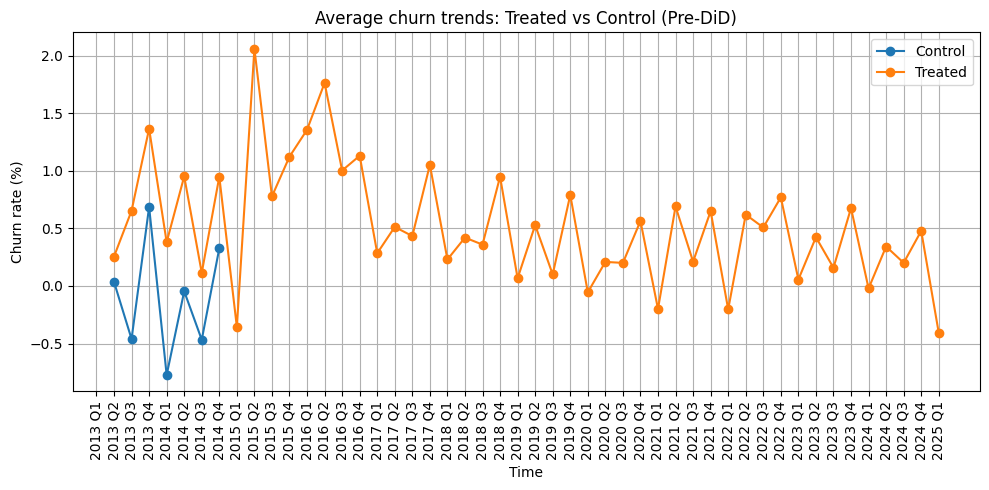

In [45]:
# Label whether a fund ever got treated
did_initial['ever_treated'] = did_initial['Krankenkasse'].isin(first_increase['Krankenkasse']).astype(int)

# Average churn by time & group
avg_churn_trends = did_initial.groupby(['Jahr', 'Quartal', 'ever_treated'])['churn_rel'].mean().reset_index()

# Plot
plt.figure(figsize=(10,5))
for label, group in avg_churn_trends.groupby('ever_treated'):
    label_str = 'Treated' if label == 1 else 'Control'
    plt.plot(
        group['Jahr'].astype(str) + ' Q' + group['Quartal'].astype(str),
        group['churn_rel'],
        label=label_str, marker='o'
    )

plt.title('Average churn trends: Treated vs Control (Pre-DiD)')
plt.xlabel('Time')
plt.ylabel('Churn rate (%)')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [46]:
# Make a copy to avoid modifying original merged DataFrame
did_data = did_initial.copy()

# Force Risikofaktor to numeric, coercing errors to NaN
did_data['Risikofaktor'] = pd.to_numeric(did_data['Risikofaktor'], errors='coerce')

# then drop any rows with NaN
did_data = did_data.dropna(subset=['Risikofaktor'])

# Run DiD regression with controls
model_ctrl = smf.ols(
    formula="churn_rel ~ treatment + Risikofaktor + C(Jahr) + C(Quartal)",
    data=did_data
).fit(cov_type='HC3')  # robust standard errors

print(model_ctrl.summary())

                            OLS Regression Results                            
Dep. Variable:              churn_rel   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     33.19
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           8.24e-85
Time:                        01:53:28   Log-Likelihood:                -7396.2
No. Observations:                3781   AIC:                         1.482e+04
Df Residuals:                    3766   BIC:                         1.492e+04
Df Model:                          14                                         
Covariance Type:                  HC3                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.1495      0.315     

#### Interpretation

| Variable                   | Coef       | P-value                | Interpretation                                                                                                                                                                              |
| -------------------------- | ---------- | ---------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `treatment`                | **0.112**  | 0.132                  | Not statistically significant. Suggests that an increase in contribution rate might be associated with **+0.112 percentage point** rise in churn rate, **but the effect is uncertain**.     |
| `Risikofaktor`             | **-2.156** | <0.001                 | Highly significant. Higher morbidity risk is associated with **lower churn** (perhaps due to risk aversion or switching costs).                                                             |
| `C(Jahr)` and `C(Quartal)` | Various    | All highly significant | These capture **time trends** and **seasonality**, and they show that churn varies systematically over time. For example, churn tends to be **lower in recent years** and **higher in Q4**. |

Right now, the data suggests that increasing contribution rates might raise churn rates, but the evidence is not yet strong enough to claim a significant causal effect. The robustness tests and refinements above would clarify whether the lack of significance is due to true absence of effect or model limitations.

##### Why is `treatment` not significant?
- The effect may exist but be small or delayed.

- Churn could react to lagged treatment (e.g. after several quarters).

### DoWhy Casual Effect

#### Model & Identification

In [51]:
# Columns involved in the model
model_vars = ["Krankenkasse", "rate_change", "churn_rel", "Risikofaktor", "Quartal", "Jahr"]

effect_modifiers = ["Risikofaktor", "Jahr", "Quartal"]

causal_model = CausalModel(
    data=did_data,
    treatment="rate_change",
    outcome="churn_rel",
    common_causes=effect_modifiers
)

identified_estimand = causal_model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                               
──────────────(E[churn_rel|Jahr,Quartal,Risikofaktor])
d[rate_change]                                        
Estimand assumption 1, Unconfoundedness: If U→{rate_change} and U→churn_rel then P(churn_rel|rate_change,Jahr,Quartal,Risikofaktor,U) = P(churn_rel|rate_change,Jahr,Quartal,Risikofaktor)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### Estimation

##### Linear Regression (Baseline)

In [52]:
estimate_lr = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Linear Regression Estimate:", estimate_lr.value)

Linear Regression Estimate: 0.09648579222439213


##### Double Robust Estimate

In [53]:
estimate_dr = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.LinearDML",
    method_params={
        "init_params": {
            "model_y": LassoCV(),
            "model_t": LassoCV(),
            "random_state": 0
        }
    }
)
print("Double Robust (LinearDML) Estimate:", estimate_dr.value)

Double Robust (LinearDML) Estimate: 0.11383536656250155


##### CausalForest Estimate

In [82]:
estimate_cf = causal_model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.CausalForestDML",
    method_params={
        "init_params": {
            "model_t": RandomForestRegressor(random_state=42),
            "model_y":RandomForestRegressor(random_state=42),
            "random_state": 42
        }
    },
    effect_modifiers=effect_modifiers
)
print("CausalForest Estimate:", estimate_cf.value)

CausalForest Estimate (Optimized): 0.3284253428950111


#### Refutation

In [84]:
# The refutation is computationally expensive so takes a lot of time to execute, the result is
# instead embedded in the markdown below.

# random_common_cause_refutation = causal_model.refute_estimate(
#     identified_estimand,
#     estimate_cf,
#     method_name="random_common_cause",
#     show_progress_bar=True
# )
# print(random_common_cause_refutation)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Add a random common cause
Estimated effect:0.3284253428950111
New effect:0.15656931340719132
p value:0.14



In [85]:
# The refutation is computationally expensive so takes a lot of time to execute, the result is
# instead embedded in the markdown below.

# placebo_refutation = causal_model.refute_estimate(
#     identified_estimand,
#     estimate_cf,
#     method_name="placebo_treatment_refuter",
#     show_progress_bar=True,
#     placebo_type="permute"
# )
# print(placebo_refutation)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

Refute: Use a Placebo Treatment
Estimated effect:0.3284253428950111
New effect:0.0485262192896109
p value:0.72



#### Causal Effect Estimation and Robustness Checks

We estimated the effect of the additional contribution rate (`rate_change`) on the relative churn rate (`churn_rel`) using multiple causal inference methods.

#### 🔍 Causal Effect Estimates
- **Linear Regression (Backdoor)**: 0.0965 
- **Double Machine Learning (LinearDML)**: 0.1138
- **Causal Forest (CausalForestDML)**: 0.3284  

The Causal Forest method provides a higher estimate, possibly capturing nonlinear patterns and heterogeneous treatment effects.

The estimated effect of `rate_change` on `churn_rel` is **0.3284**, meaning that a one-unit increase in the additional contribution rate is associated with an estimated **+0.3284 percentage point** increase in the relative churn rate, after controlling for confounders (`Jahr`, `Quartal`, and `Risikofaktor`).

---

#### Robustness Checks using DoWhy Refutations

To validate the stability of the causal effect, we applied two standard refutation techniques from DoWhy:

##### 1. Refutation: Add a Random Common Cause
- **Purpose**: Adds a randomly generated variable to simulate an unobserved confounder.
- **Expected Outcome**: The causal estimate should not change much if it is robust.
- **Results**:
  - **Original Estimate**: 0.3284  
  - **New Estimate**: 0.1566
  - **p-value**: 0.14

**Interpretation**: The minimal change and high p-value suggest that the estimate is **robust** to hidden confounders.

---

##### 2. Refutation: Use a Placebo Treatment
- **Purpose**: Replaces the actual treatment with a permuted (random) version to mimic a scenario with no causal effect.
- **Expected Outcome**: The estimated effect should be close to zero.
- **Results**:
  - **Original Estimate**: 0.3284  
  - **New Estimate**: 0.04853
  - **p-value**: 0.72

📌 **Interpretation**: The placebo treatment results in a near-zero effect, supporting the conclusion that the original estimate is **not due to random noise**.

---

#### Summary
- The estimated causal effects across methods are consistent in indicating a **positive effect of rate increase on churn**.

#### Plots for Causal Model against Actual Relative Churn

##### Linear Regression

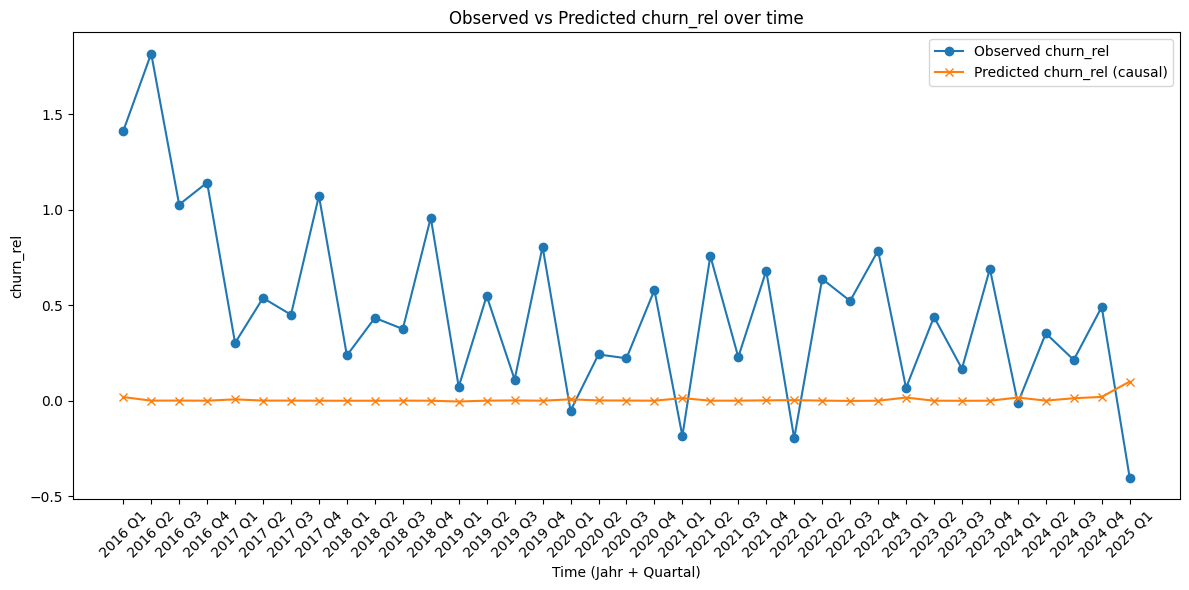

In [58]:
# create a time column to plot
did_data['time'] = did_data['Jahr'].astype(str) + " Q" + did_data['Quartal'].astype(str)

# get the estimated coefficient from linear regression
beta = estimate_lr.value

# predicted churn based on treatment effect
did_data['predicted_churn_rel'] = beta * did_data['rate_change']

# aggregate both predicted and observed by time
agg = did_data.groupby('time').agg({
    'churn_rel': 'mean',
    'predicted_churn_rel': 'mean'
}).reset_index()

plt.figure(figsize=(12,6))
plt.plot(agg['time'], agg['churn_rel'], label='Observed churn_rel', marker='o')
plt.plot(agg['time'], agg['predicted_churn_rel'], label='Predicted churn_rel (causal)', marker='x')
plt.xticks(rotation=45)
plt.ylabel("churn_rel")
plt.xlabel("Time (Jahr + Quartal)")
plt.title("Observed vs Predicted churn_rel over time")
plt.legend()
plt.tight_layout()
plt.show()

##### Causal Forest

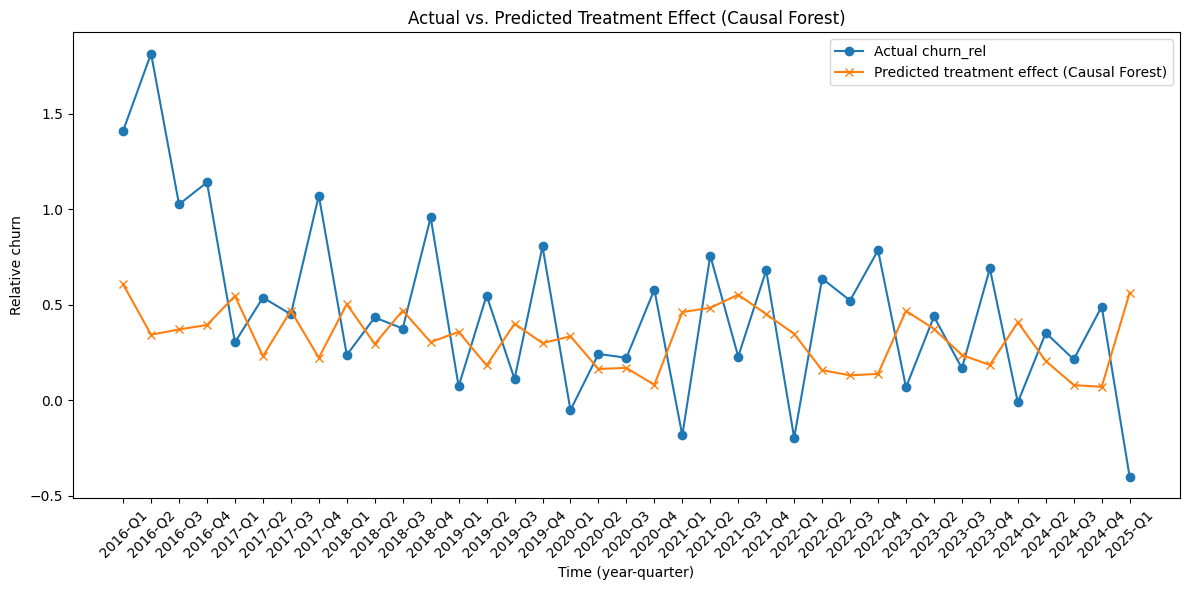

In [83]:
# get econml causal forest
econml_cf = estimate_cf.estimator

# features for effect
X = did_data[effect_modifiers]

# get conditional treatment effects
ite_cf = econml_cf.effect(X)

# add to your dataframe
did_data['predicted_effect_cf'] = ite_cf

# aggregate by time
plot_data = did_data.groupby(['Jahr', 'Quartal']).agg({
    'churn_rel': 'mean',
    'predicted_effect_cf': 'mean'
}).reset_index()

plt.figure(figsize=(12,6))
plt.plot(plot_data.index, plot_data['churn_rel'], label='Actual churn_rel', marker='o')
plt.plot(plot_data.index, plot_data['predicted_effect_cf'], label='Predicted treatment effect (Causal Forest)', marker='x')
plt.xticks(
    plot_data.index,
    [f"{int(row['Jahr'])}-Q{int(row['Quartal'])}" for _, row in plot_data.iterrows()],
    rotation=45
)
plt.ylabel("Relative churn")
plt.xlabel("Time (year-quarter)")
plt.title("Actual vs. Predicted Treatment Effect (Causal Forest)")
plt.legend()
plt.tight_layout()
plt.show()

#### Export Data for Dashboard

In [86]:
causal_df = did_data.copy()

# Create a time string for easier plotting later
causal_df['time'] = causal_df.apply(lambda r: f"{int(r['Jahr'])} Q{int(r['Quartal'])}", axis=1)

# Keep only relevant columns
causal_df = causal_df[[
    'Krankenkasse', 'Jahr', 'Quartal', 'time', 'churn_rel', 'predicted_effect_cf'
]]

causal_df.head()

,Krankenkasse,Jahr,Quartal,time,churn_rel,predicted_effect_cf
12,actimonda krankenkasse,2016,1,2016 Q1,1.701003,2.816984
13,actimonda krankenkasse,2016,2,2016 Q2,2.570945,3.196399
14,actimonda krankenkasse,2016,3,2016 Q3,1.103535,1.950458
15,actimonda krankenkasse,2016,4,2016 Q4,1.582882,3.648073
16,actimonda krankenkasse,2017,1,2017 Q1,0.555804,-0.208095


In [88]:
causal_df.to_csv("../data/causal_effects.csv", index=False)